In this tutorial, we will learn several integration methods and see how each one works, along with their strengths and weaknesses. We will use a pendulum model as our example:
$$
\dot{q} = \begin{bmatrix}
    \dot{\theta} \\
    \dot{\omega} 
\end{bmatrix} = 
\begin{bmatrix} 
    \omega \\
    -\frac{g}{l} \sin(\theta)
\end{bmatrix} = f(q).
$$

In [49]:
from math import sin, pi
import numpy as np
def pendulum_dynamics(q):
    l = 1.0
    g = 9.81
    
    theta = q[0]
    theta_dot = q[1]
    
    theta_ddot = -(g/l)*sin(theta)
    
    return np.array([theta_dot, theta_ddot])

## Forward (Explicit) Euler
Forward (explicit) Euler applies a first-order (in time) Taylor expansion as follows:
$$
\dot{q}(t) \approx \frac{q(t + \Delta t) - q(t)}{\Delta t}.
$$
Let $q_k$ and $q_{k+1}$ denote $q(t)$ and $q(t + \Delta t)$, respectively.
$$
\begin{aligned}
    \frac{q_{k+1} - q_k}{\Delta t} &= f(q_k) \\
    q_{k+1} &= q_k + f(q_k) \Delta t 
\end{aligned}
$$

In [50]:
def forward_euler(dyn_fun, q0, Tf, dt):
    t = np.arange(0, Tf, dt)
    num_points = len(t)
    dim_x = len(q0)
    q_hist = np.zeros((dim_x, num_points))
    q_hist[:,0] = q0
    
    for k in range(num_points-1):
        q_hist[:,k+1] = q_hist[:,k] + dt*dyn_fun(q_hist[:,k])
        
    return q_hist, t

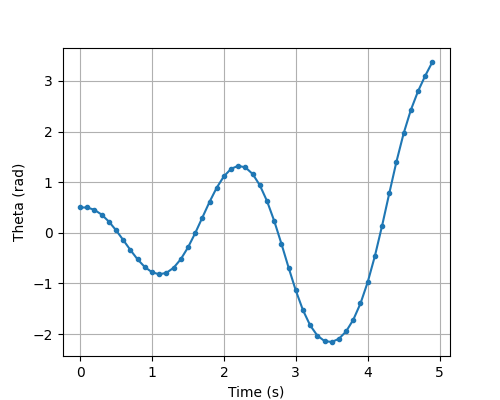

In [51]:
%matplotlib ipympl
import matplotlib.pyplot as plt
q0 = np.array([0.5, 0.])
q_hist, t_hist = forward_euler(pendulum_dynamics,
                               q0,
                               Tf=5,
                               dt=0.1)
plt.figure(figsize=(5, 4))
plt.plot(t_hist, q_hist[0,:], "-o", markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.grid()
plt.show()

Key takeaway:
Forward Euler is simple and cheap but can be unstable or energy–non-conserving for oscillatory / stiff systems.

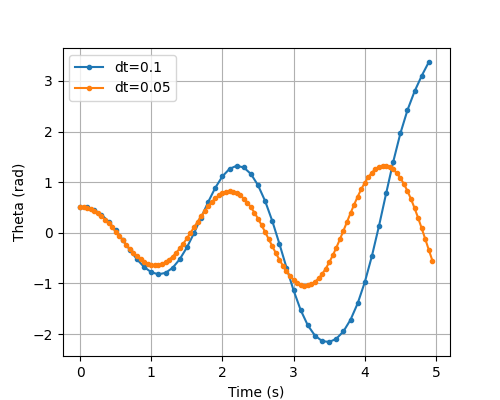

In [52]:
q_hist_1, t_hist_1 = forward_euler(pendulum_dynamics,
                                   q0,
                                   Tf=5,
                                   dt=0.05)
plt.figure(figsize=(5, 4))
plt.plot(t_hist, q_hist[0,:], "-o", markersize=3, label="dt=0.1")
plt.plot(t_hist_1, q_hist_1[0,:], "-o", markersize=3, label="dt=0.05")
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.legend()
plt.grid()
plt.show()

# Runge–Kutta methods
For better integration accuracy, we consider the 4th order Runge-Kutta method (RK4). This method update the state $q$ using the intermediate information:

$$
\begin{aligned}
    k_1 &= f(q_k) \\
    k_2 &= f(q_k + 0.5 k_1 \Delta t) \\
    k_3 &= f(q_k + 0.5 k_2 \Delta t) \\
    k_4 &= f(q_k + k_3 \Delta t) \\
    q_{k+1} &= q_k + \frac{\Delta t}{6}(k_1 + 2 k_2 + 2 k_3 + k_4) 
\end{aligned}
$$

[Here](https://www.youtube.com/watch?v=HOWJp8NV5xU&list=PLMrJAkhIeNNTYaOnVI3QpH7jgULnAmvPA&index=44) is a clear explanation of the RK4 method.

In [53]:
def fd_pendulum_rk4(qk, dt):
    f1 = pendulum_dynamics(qk)
    f2 = pendulum_dynamics(qk + 0.5*dt*f1)
    f3 = pendulum_dynamics(qk + 0.5*dt*f2)
    f4 = pendulum_dynamics(qk + dt*f3)
    return qk + (dt/6.0)*(f1 + 2*f2 + 2*f3 + f4)

def RK4(q0, Tf, dt):
    t = np.arange(0, Tf, dt)
    num_points = len(t)
    dim_x = len(q0)
    q_hist = np.zeros((dim_x, num_points))
    q_hist[:,0] = q0
    
    for k in range(num_points-1):
        q_hist[:,k+1] = fd_pendulum_rk4(q_hist[:,k], dt)

    return q_hist, t

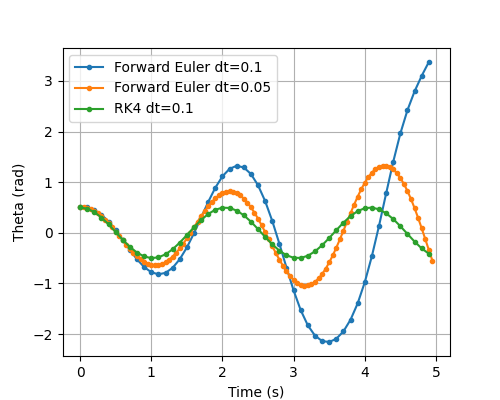

In [54]:
q_hist_rk, t_hist_rk = RK4(q0,
                           Tf=5,
                           dt=0.1)
plt.figure(figsize=(5, 4))
plt.plot(t_hist, q_hist[0,:], "-o", markersize=3, label="Forward Euler dt=0.1")
plt.plot(t_hist_1, q_hist_1[0,:], "-o", markersize=3, label="Forward Euler dt=0.05")
plt.plot(t_hist_rk, q_hist_rk[0,:], "-o", markersize=3, label="RK4 dt=0.1")
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.legend()
plt.grid()
plt.show()

## Backward (Implicit) Euler
Backward Euler uses the slope at the unknown future state:
$$\frac{q_{k+1}-q_k}{\Delta t} = f(q_{k+1}), \quad \text{so}\quad q_{k+1} = q_k + \Delta t\, f(q_{k+1}).$$
For oscillatory systems (like the undamped pendulum), this method introduces numerical damping of energy.

We solve the nonlinear equation for $q_{k+1}$ with Newton's method on the residual
$$R(q_{k+1}) = q_{k+1} - q_k - \Delta t f(q_{k+1}) = 0.$$

The Newton step at iterate $q_{k+1}^i$ solves
$$J_R(q_{k+1}^i)\,\Delta q_{k+1}^i = -R(q_{k+1}^i), \qquad q_{k+1}^{i+1}=q_{k+1}^i+\Delta q_{k+1}^i,$$

where $J_R(q) = I - \Delta t\, \partial f/\partial q (q)$.

### Analytic Jacobian for the pendulum
State $q=[\theta,\omega]^T$, dynamics $f(q) = [\omega, -(g/l)\sin\theta]^T$.
$$\frac{\partial f}{\partial q}(q)= \begin{bmatrix}0 & 1\\ -(g/l)\cos\theta & 0\end{bmatrix}, \qquad J_R(q)=\begin{bmatrix}1 & -\Delta t\\ (g/l)\Delta t\cos\theta & 1\end{bmatrix}.$$

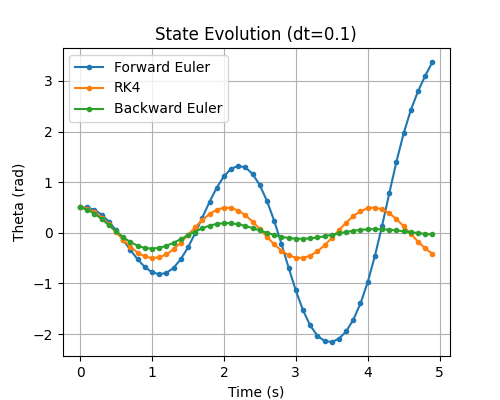

In [55]:
def dynamics_jacobian(q):
    g = 9.81
    l = 1.0
    theta = q[0]
    
    df_dq = np.array([[0.0, 1.0],
                      [-(g/l)*np.cos(theta), 0.0]])
    
    return df_dq

def backward_euler_step(dyn_fun, dyn_jac, qk, dt, max_iter=50, tol=1e-12):
    # initial guess: forward Euler
    q_next = qk + dt * dyn_fun(qk)
    for _ in range(max_iter):
        f_val = dyn_fun(q_next)
        res = q_next - qk - dt * f_val
        if np.linalg.norm(res) < tol:
            break
        df_dq = dyn_jac(q_next)
        JR = np.eye(2) - dt * df_dq
        delta = np.linalg.solve(JR, -res)
        q_next = q_next + delta
        
    return q_next

def backward_euler(dyn_fun, dyn_jac, q0, Tf, dt):
    t = np.arange(0, Tf, dt)
    q_hist = np.zeros((len(q0), len(t)))
    q_hist[:,0] = q0
    for k in range(len(t)-1):
        q_hist[:,k+1] = backward_euler_step(dyn_fun, dyn_jac, q_hist[:,k], dt)
    return q_hist, t

q_be, t_be = backward_euler(pendulum_dynamics, dynamics_jacobian, q0, Tf=5, dt=0.1)

plt.figure(figsize=(5,4))
plt.plot(t_hist, q_hist[0], '-o', ms=3, label='Forward Euler')
plt.plot(t_hist_rk, q_hist_rk[0], '-o', ms=3, label='RK4')
plt.plot(t_be, q_be[0], '-o', ms=3, label='Backward Euler')
plt.xlabel('Time (s)') 
plt.ylabel('Theta (rad)') 
plt.legend(); plt.grid() 
plt.title('State Evolution (dt=0.1)')
plt.show()

## Other integration methods
- Semi-implicit Euler method

- Collocation-based integration (higher-order implicit methods)